In [1]:
import pennylane as qml
import tensorflow as tf
import sklearn.datasets
from sklearn.datasets import fetch_openml

import numpy as np

from matplotlib import pyplot as plt

tf.keras.backend.set_floatx('float64')

## Load and reduce the data

Load the MNIST data and check number of training and test examples

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Rescale the images from [0,255] to the [0.0,1.0] range.
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0  # add colour dimension

print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

Number of original training examples: 60000
Number of original test examples: 10000


Create a function to filter out only 3 and 6

In [3]:
def filter_01(x, y):
    keep = (y == 3) | (y == 6)
    x, y = x[keep], y[keep]
    y = y == 3
    return x,y

In [4]:
x_train, y_train = filter_01(x_train, y_train)
x_test, y_test = filter_01(x_test, y_test)

print("Number of filtered training examples:", len(x_train))
print("Number of filtered test examples:", len(x_test))

Number of filtered training examples: 12049
Number of filtered test examples: 1968


Plot the original images

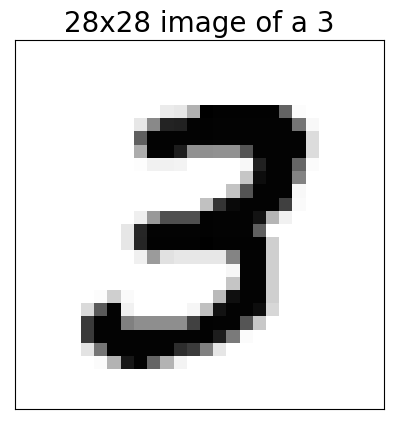

In [5]:
plt.imshow(x_train[0, :, :, 0], cmap='Greys')
ax = plt.gca()
ax.set_xticks([])
ax.set_yticks([])
plt.title("28x28 image of a 3", fontsize=20)
# save to file as pdf
plt.savefig('28x28_MNIST_3.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

Reduce images to 9x9

In [6]:
x_train_small = tf.image.resize(x_train, (9,9)).numpy()
x_test_small = tf.image.resize(x_test, (9,9)).numpy()

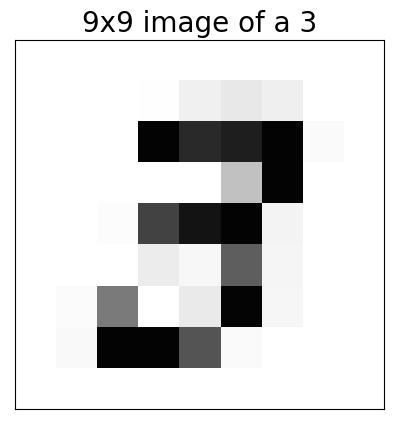

In [7]:
plt.imshow(x_train_small[0,:,:,0], vmin=0, vmax=1, cmap='Greys')
ax = plt.gca()
ax.set_xticks([])
ax.set_yticks([])
plt.title("9x9 image of a 3", fontsize=20)
# save to file as pdf
plt.savefig('9x9_MNIST_3.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

Further reduce images to 9x1

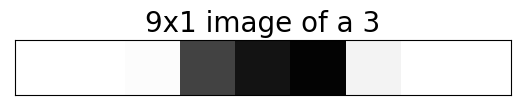

In [8]:
x_train_small = x_train_small[:,4,:,:].reshape((-1,9))  # take only central slices
x_test_small = x_test_small[:,4,:,:].reshape((-1,9))  # take only central slices

plt.imshow(x_train_small[0,:].reshape((1,-1)), vmin=0, vmax=1, cmap='Greys')
ax = plt.gca()
ax.set_xticks([])
ax.set_yticks([])
plt.title("9x1 image of a 3", fontsize=20)
# save to file as pdf
plt.savefig('9x1_MNIST_3.pdf', bbox_inches='tight', pad_inches=0)
plt.show()


In [9]:
x_train_small.shape

(12049, 9)

In [10]:
flattened_images_train = x_train.reshape(x_train.shape[0], -1)
flattened_images_test = x_test.reshape(x_test.shape[0], -1)

## Set up the Quantum Neural Network

Create quantum circuit using pennylane qnode, then conver this to a Keras layer to make a Keras model

In [28]:
n_qubits = 11
n_layers = 1
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev, diff_method="adjoint")
def qnode(inputs, weights):

#     for ii in range(n_qubits):
#         qml.RY(np.pi * inputs[ii], wires=ii)

    newinputs =[]
    
#     for j in range(0,1264):
        
        
        
#         if j <=783:
#             newinputs.append( np.cos( np.pi * inputs[j] /2 )/ np.sqrt(784)   )
#             newinputs.append(      np.sin( np.pi * inputs[j] /2)/np.sqrt(784)    )
           
#         else :
            
#             newinputs.append(0)
    
    
    for i in inputs :
        
        newinputs.append( np.cos( np.pi * i /2 )   )
        newinputs.append( np.sin( np.pi * i /2)   )
        
        
        
        
    
    
    qml.AmplitudeEmbedding(features=newinputs,pad_with=0, wires=range(11),normalize=True)
    

    for jj in range(n_layers):
        for ii in range(n_qubits-1):
            qml.RZ(weights[jj,2*ii,0], wires=0)
            qml.RY(weights[jj,2*ii,1], wires=0)
            qml.RZ(weights[jj,2*ii,2], wires=0)

            qml.RZ(weights[jj,2*ii+1,0], wires=ii+1)
            qml.RY(weights[jj,2*ii+1,1], wires=ii+1)
            qml.RZ(weights[jj,2*ii+1,2], wires=ii+1)

            #qml.U3(*list(weights[jj,2*ii,:]), wires=0)
            #qml.U3(*list(weights[jj,2*ii+1,:]), wires=ii+1)
            qml.CNOT(wires=[ii+1,0])
            
        qml.RZ(weights[jj,2*(n_qubits-1),0], wires=0)
        qml.RY(weights[jj,2*(n_qubits-1),1], wires=0)
        qml.RZ(weights[jj,2*(n_qubits-1),2], wires=0)

    return qml.expval(qml.PauliZ(0))

weight_shapes = {"weights": (n_layers, 2*(n_qubits-1)+1, 3) }


qlayer = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=1, name="quantumLayer")
inputs = tf.keras.Input(shape=(784,), name="inputs")
outputs = qlayer(inputs)
model = tf.keras.Model(inputs=inputs, outputs=outputs, name="QNN")

# model.predict(x_train_small[0,:])
print(model.summary())

Model: "QNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 784)]             0         
                                                                 
 quantumLayer (KerasLayer)   (None, 1)                 0 (unused)
                                                                 
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________
None


In [29]:
# weights =np.random.normal(size=(1, 9, 3)) 
# inputs = np.random.normal(size=(9,)) 
# fig, ax = qml.draw_mpl(qnode, decimals=2)(inputs,weights)
# fig.show()

Redefine the classification values to match the Hinge loss

In [30]:
y_train_hinge = 2.0*y_train-1.0
y_test_hinge = 2.0*y_test-1.0

Define the hinge accuracy

In [31]:
def hinge_accuracy(y_true, y_pred):
    y_true = tf.squeeze(y_true) > 0.0
    y_pred = tf.squeeze(y_pred) > 0.0
    result = tf.cast(y_true == y_pred, tf.float32)

    return tf.reduce_mean(result)

## Compile and train the model

Compile the model using the hinge loss and accuracy and the Adam optimiser

In [32]:
model.compile(
    loss=tf.keras.losses.Hinge(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[hinge_accuracy])

In [33]:
print(model.summary())

Model: "QNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 784)]             0         
                                                                 
 quantumLayer (KerasLayer)   (None, 1)                 0 (unused)
                                                                 
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________
None


Train the model over 20 epochs

In [34]:
EPOCHS = 100
BATCH_SIZE = 32

NUM_EXAMPLES = 512 #x_train_small.shape[0]
print(NUM_EXAMPLES)

flattened_images_train = flattened_images_train[:NUM_EXAMPLES,:]
y_train_hinge_sub = y_train_hinge[:NUM_EXAMPLES]

flattened_images_test = flattened_images_test[:,:]
y_test_sub = y_test[:]

qnn_history_1layer = model.fit(
      flattened_images_train, y_train_hinge_sub,
      batch_size=BATCH_SIZE,
      epochs=EPOCHS,
      verbose=1)#,
      #validation_data=(x_test_sub, y_test_sub))

qnn_results_1layer = model.evaluate(flattened_images_test, y_test_sub)

512
Epoch 1/100
16/16 [==============================] - 633s 39s/step - loss: 1.0031 - hinge_accuracy: 0.4902
Epoch 2/100
16/16 [==============================] - 582s 36s/step - loss: 1.0023 - hinge_accuracy: 0.4902
Epoch 3/100
16/16 [==============================] - 566s 35s/step - loss: 1.0017 - hinge_accuracy: 0.4902
Epoch 4/100
16/16 [==============================] - 366s 22s/step - loss: 1.0012 - hinge_accuracy: 0.4902
Epoch 5/100
16/16 [==============================] - 259s 16s/step - loss: 1.0006 - hinge_accuracy: 0.4902
Epoch 6/100
16/16 [==============================] - 260s 16s/step - loss: 1.0002 - hinge_accuracy: 0.4902
Epoch 7/100
16/16 [==============================] - 266s 17s/step - loss: 0.9996 - hinge_accuracy: 0.4902
Epoch 8/100
16/16 [==============================] - 267s 17s/step - loss: 0.9991 - hinge_accuracy: 0.4902
Epoch 9/100
16/16 [==============================] - 269s 17s/step - loss: 0.9988 - hinge_accuracy: 0.4902
Epoch 10/100
16/16 [=============

16/16 [==============================] - 343s 21s/step - loss: 0.9154 - hinge_accuracy: 0.9219
Epoch 77/100
16/16 [==============================] - 343s 21s/step - loss: 0.9148 - hinge_accuracy: 0.9199
Epoch 78/100
16/16 [==============================] - 342s 21s/step - loss: 0.9144 - hinge_accuracy: 0.9199
Epoch 79/100
16/16 [==============================] - 339s 21s/step - loss: 0.9140 - hinge_accuracy: 0.9180
Epoch 80/100
16/16 [==============================] - 338s 21s/step - loss: 0.9136 - hinge_accuracy: 0.9180
Epoch 81/100
16/16 [==============================] - 350s 22s/step - loss: 0.9132 - hinge_accuracy: 0.9180
Epoch 82/100
16/16 [==============================] - 346s 22s/step - loss: 0.9129 - hinge_accuracy: 0.9160
Epoch 83/100
16/16 [==============================] - 341s 21s/step - loss: 0.9125 - hinge_accuracy: 0.9121
Epoch 84/100
16/16 [==============================] - 343s 21s/step - loss: 0.9122 - hinge_accuracy: 0.9160
Epoch 85/100
16/16 [=====================

In [35]:
import os
import pickle
filename= "frqi_100_1hl_adam_adjoint.pickle"
history_path = os.path.join('history', filename)
with open(history_path, 'wb') as f:
    pickle.dump(qnn_history_1layer.history, f, pickle.HIGHEST_PROTOCOL)

In [18]:
import pickle

pickle.dump(model, open('frqi_60_epochs_1_ansatz.pkl', 'wb'))

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers\input_layer
......vars
...layers\keras_layer
......vars
.........0
...metrics\mean
......vars
.........0
.........1
...metrics\mean_metric_wrapper
......vars
.........0
.........1
...optimizer
......vars
.........0
.........1
.........2
...vars
Keras model archive saving:
File Name                                             Modified             Size
config.json                                    2023-04-24 17:54:35         1541
metadata.json                                  2023-04-24 17:54:35           64
variables.h5                                   2023-04-24 17:54:35        16144


Create and train a 2 layer version of the QNN

In [19]:
n_qubits = 11
n_layers = 2
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev, diff_method="adjoint")
def qnode(inputs, weights):

    newinputs =[]
    
    for j in range(0,1264):
        
        
        
        if j <=783:
            newinputs.append( np.cos( np.pi * inputs[j] /2 )/ np.sqrt(784)   )
            newinputs.append(      np.sin( np.pi * inputs[j] /2)/np.sqrt(784)    )
           
        else :
            
            newinputs.append(0)
            
        
        
    
    
    qml.AmplitudeEmbedding(features=newinputs, wires=range(11),normalize=True,pad_with=0)
    

    for jj in range(n_layers):
        for ii in range(n_qubits-1):
            qml.RZ(weights[jj,2*ii,0], wires=0)
            qml.RY(weights[jj,2*ii,1], wires=0)
            qml.RZ(weights[jj,2*ii,2], wires=0)

            qml.RZ(weights[jj,2*ii+1,0], wires=ii+1)
            qml.RY(weights[jj,2*ii+1,1], wires=ii+1)
            qml.RZ(weights[jj,2*ii+1,2], wires=ii+1)

            #qml.U3(*list(weights[jj,2*ii,:]), wires=0)
            #qml.U3(*list(weights[jj,2*ii+1,:]), wires=ii+1)
            qml.CNOT(wires=[ii+1,0])
            
        qml.RZ(weights[jj,2*(n_qubits-1),0], wires=0)
        qml.RY(weights[jj,2*(n_qubits-1),1], wires=0)
        qml.RZ(weights[jj,2*(n_qubits-1),2], wires=0)

    return qml.expval(qml.PauliZ(0))

weight_shapes = {"weights": (n_layers, 2*(n_qubits-1)+1, 3) }


qlayer = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=1, name="quantumLayer")
inputs = tf.keras.Input(shape=(784,), name="inputs")
outputs = qlayer(inputs)
model2 = tf.keras.Model(inputs=inputs, outputs=outputs, name="QNN")

# model2.predict(x_train_small[0,:])
print(model2.summary())

Model: "QNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 784)]             0         
                                                                 
 quantumLayer (KerasLayer)   (None, 1)                 0 (unused)
                                                                 
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________
None


In [20]:
model2.compile(
    loss=tf.keras.losses.Hinge(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[hinge_accuracy])

In [21]:
EPOCHS = 20
BATCH_SIZE = 32

NUM_EXAMPLES = 512 #x_train_small.shape[0]
print(NUM_EXAMPLES)

flattened_images_train = flattened_images_train[:NUM_EXAMPLES,:]
y_train_hinge_sub = y_train_hinge[:NUM_EXAMPLES]

flattened_images_test = flattened_images_test[:,:]
y_test_sub = y_test[:]

qnn_history_2layer = model2.fit(
      flattened_images_train, y_train_hinge_sub,
      batch_size=BATCH_SIZE,
      epochs=EPOCHS,
      verbose=1)#,
      #validation_data=(x_test_sub, y_test_sub))

qnn_results_2layer = model2.evaluate(x_test_sub, y_test_sub)

512
Epoch 1/20
16/16 [==============================] - 418s 26s/step - loss: 1.0149 - hinge_accuracy: 0.4902
Epoch 2/20
16/16 [==============================] - 420s 26s/step - loss: 1.0121 - hinge_accuracy: 0.4902
Epoch 3/20
16/16 [==============================] - 410s 26s/step - loss: 1.0098 - hinge_accuracy: 0.4902
Epoch 4/20
16/16 [==============================] - 387s 24s/step - loss: 1.0070 - hinge_accuracy: 0.4902
Epoch 5/20
16/16 [==============================] - 389s 24s/step - loss: 1.0048 - hinge_accuracy: 0.4902
Epoch 6/20
16/16 [==============================] - 402s 25s/step - loss: 1.0026 - hinge_accuracy: 0.4902
Epoch 7/20
16/16 [==============================] - 396s 25s/step - loss: 1.0006 - hinge_accuracy: 0.4902
Epoch 8/20
16/16 [==============================] - 390s 24s/step - loss: 0.9988 - hinge_accuracy: 0.4902
Epoch 9/20
16/16 [==============================] - 388s 24s/step - loss: 0.9970 - hinge_accuracy: 0.4902
Epoch 10/20
16/16 [=======================

KeyboardInterrupt: 

## Plot the results!

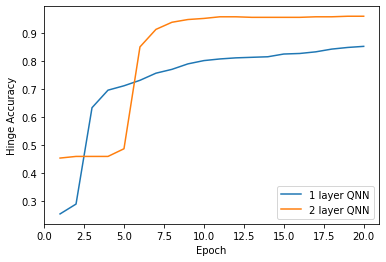

In [55]:
# plot the hinge accuracy for the qnn history for both 1 and 2 layer on the same axes
plt.plot(np.arange(1,21), qnn_history_1layer.history["hinge_accuracy"], label="1 layer QNN")
plt.plot(np.arange(1,21), qnn_history_2layer.history["hinge_accuracy"], label="2 layer QNN")
plt.xlabel("Epoch")
plt.ylabel("Hinge Accuracy")
plt.legend()
# modify x_ticks to also include 20
plt.xticks(np.arange(0, 21, 2.5))
# save as pdf with tight layout and no padding
plt.savefig("qnn_hinge_accuracy.pdf", bbox_inches="tight", pad_inches=0)
plt.show()

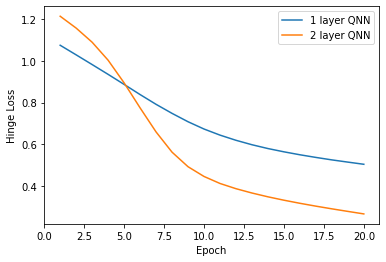

In [56]:
# plot the hinge accuracy for the loss for both 1 and 2 layer on the same axes
plt.plot(np.arange(1,21), qnn_history_1layer.history["loss"], label="1 layer QNN")
plt.plot(np.arange(1,21), qnn_history_2layer.history["loss"], label="2 layer QNN")
plt.xlabel("Epoch")
plt.ylabel("Hinge Loss")
plt.legend()
# modify x_ticks to also include 20
plt.xticks(np.arange(0, 21, 2.5))
# save as pdf with tight layout and no padding
plt.savefig("qnn_hinge_loss.pdf", bbox_inches="tight", pad_inches=0)
plt.show()